In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('agriculture_data.csv')

# Display initial info
print("Initial Data Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Step 1: Handle missing values
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Replace any potential placeholders for missing data (e.g., empty strings, 'NA')
df.replace('', np.nan, inplace=True)

# For numerical columns, fill missing values with 0 (assuming no holdings/area implies 0)
numerical_cols = [
    'Wholly irrigated holdings', 'Area of wholly irrigated holdings',
    'Wholly unirrigated holdings', 'Area of wholly unirrigated holdings',
    'Partially irrigated holdings', 'Irrigated area of partially irrigated holdings',
    'Area of partially irrigated holdings', 'Holdings receiving irrigation',
    'Net irrigated area of holdings receiving irrigation'
]
df[numerical_cols] = df[numerical_cols].fillna(0)

# For categorical columns, fill with 'Unknown' or mode if appropriate
categorical_cols = ['Country', 'State', 'District', 'Social group type', 'Land area size', 'Category of holdings']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Step 2: Correct data types
# Ensure numerical columns are float/int
df[numerical_cols] = df[numerical_cols].astype(float)

# Ensure categorical columns are strings
df[categorical_cols] = df[categorical_cols].astype(str)

# Step 3: Remove duplicates
df.drop_duplicates(inplace=True)

# Step 4: Standardize text data
# Convert categorical columns to lowercase and strip whitespace
for col in categorical_cols:
    df[col] = df[col].str.lower().str.strip()

# Step 5: Handle outliers (basic approach, will refine in EDA)
# For numerical columns, cap extreme values at 99th percentile
for col in numerical_cols:
    percentile_99 = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=percentile_99)

# Step 6: Validate data
# Ensure no negative values in numerical columns (e.g., areas and holdings can't be negative)
for col in numerical_cols:
    df[col] = df[col].apply(lambda x: max(0, x))

# Save cleaned data
df.to_csv('cleaned_agriculture_data.csv', index=False)
print("\nCleaned Data Info:")
print(df.info())
print("\nCleaned Data Sample:")
print(df.head())


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26960 entries, 0 to 26959
Data columns (total 20 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   ROWID                                                26960 non-null  int64  
 1   Country                                              26960 non-null  object 
 2   State lgd code                                       26960 non-null  int64  
 3   State                                                26960 non-null  object 
 4   District lgd code                                    26960 non-null  int64  
 5   District                                             26960 non-null  object 
 6   YearCode                                             26960 non-null  int64  
 7   Year                                                 26960 non-null  object 
 8   Social group type                              

In [2]:
# Derived column: Proportion of net irrigated area to total holdings area
df['Total holdings area'] = (
    df['Area of wholly irrigated holdings'] +
    df['Area of wholly unirrigated holdings'] +
    df['Area of partially irrigated holdings']
)
df['Proportion irrigated'] = df['Net irrigated area of holdings receiving irrigation'] / df['Total holdings area'].replace(0, np.nan)

# Filter for a specific district (e.g., Anantnag)
anantnag_df = df[df['District'] == 'anantnag']

# NumPy operations: Calculate mean and std of irrigated area across districts
irrigated_areas = df['Net irrigated area of holdings receiving irrigation'].values
mean_irrigated = np.mean(irrigated_areas)
std_irrigated = np.std(irrigated_areas)
print(f"\nMean Irrigated Area: {mean_irrigated:.2f}, Std Dev: {std_irrigated:.2f}")

# Group by social group and land size
grouped = df.groupby(['Social group type', 'Land area size']).agg({
    'Holdings receiving irrigation': 'sum',
    'Net irrigated area of holdings receiving irrigation': 'mean'
}).reset_index()
print("\nGrouped Data Sample:")
print(grouped.head())


Mean Irrigated Area: 2350.87, Std Dev: 6760.43

Grouped Data Sample:
  Social group type Land area size  Holdings receiving irrigation  \
0     institutional      (0.5-1.0)                        20366.0   
1     institutional      (1.0-2.0)                        20002.0   
2     institutional    (10.0-20.0)                         5567.0   
3     institutional      (2.0-3.0)                        10713.0   
4     institutional      (3.0-4.0)                         6221.0   

   Net irrigated area of holdings receiving irrigation  
0                                          17.317625    
1                                          33.710110    
2                                         102.571881    
3                                          31.595528    
4                                          26.811476    


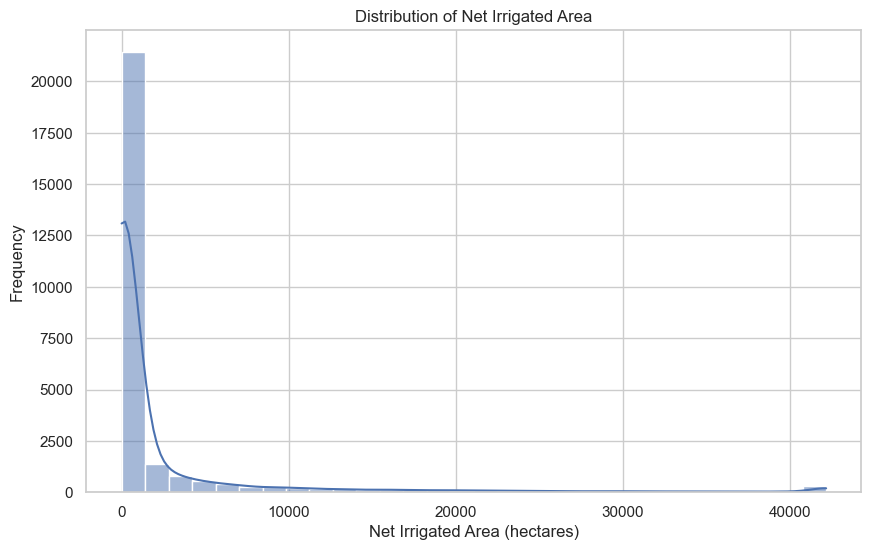

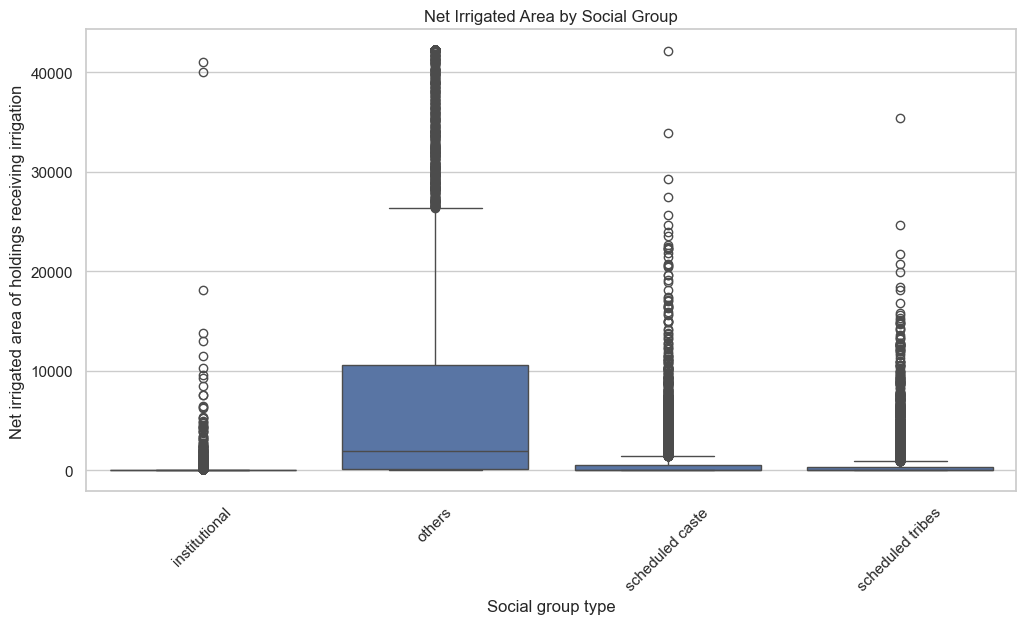

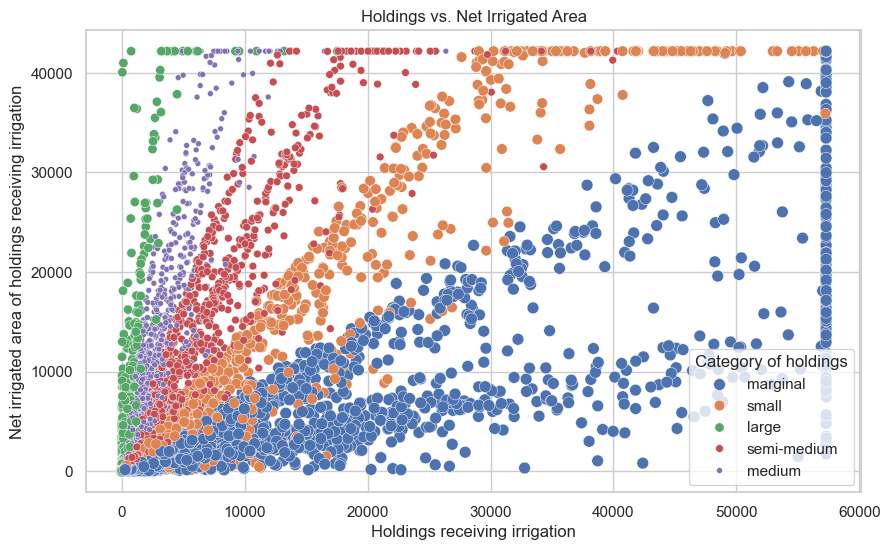

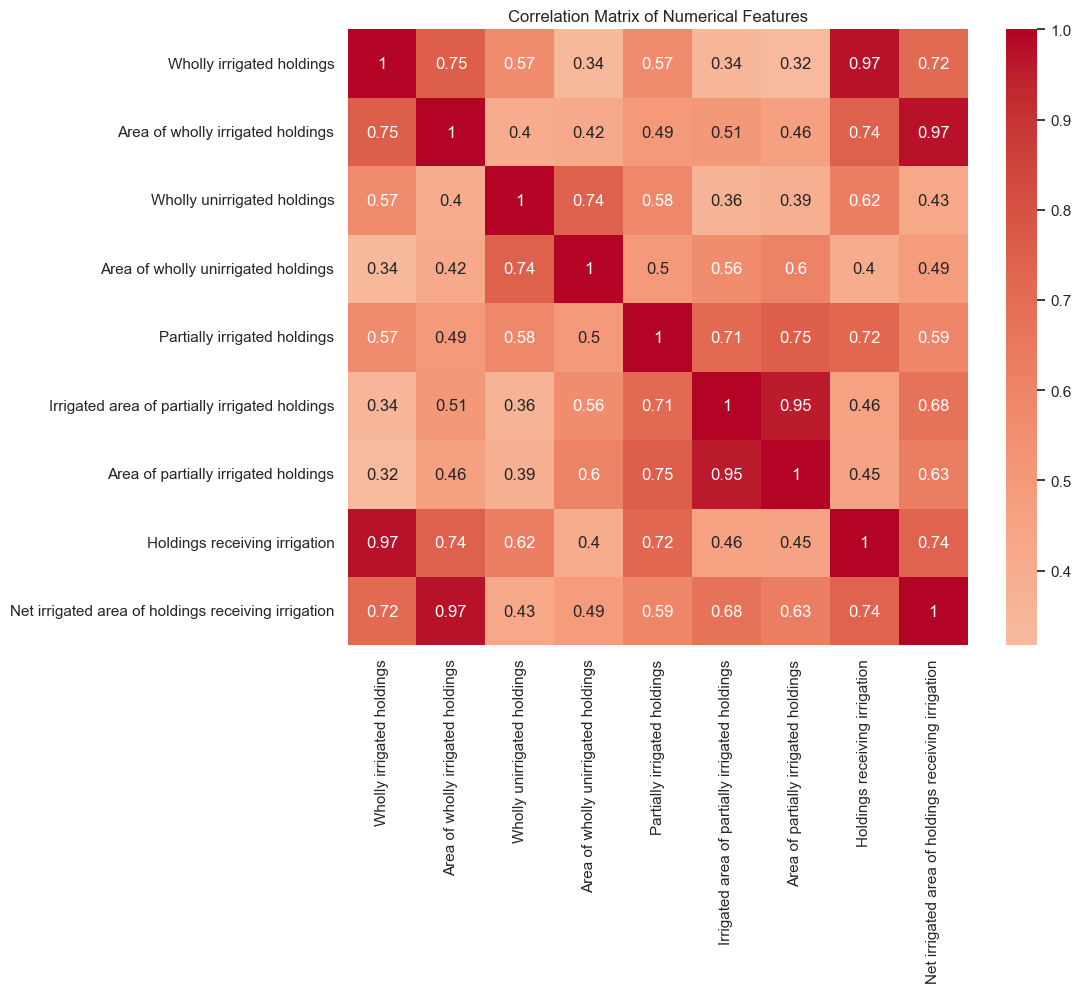

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

# Plot 1: Distribution of Net Irrigated Area
plt.figure(figsize=(10, 6))
sns.histplot(df['Net irrigated area of holdings receiving irrigation'], bins=30, kde=True)
plt.title('Distribution of Net Irrigated Area')
plt.xlabel('Net Irrigated Area (hectares)')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Boxplot of Irrigated Area by Social Group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Social group type', y='Net irrigated area of holdings receiving irrigation', data=df)
plt.title('Net Irrigated Area by Social Group')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Scatter plot of Holdings vs. Irrigated Area
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Holdings receiving irrigation', y='Net irrigated area of holdings receiving irrigation', hue='Category of holdings', size='Category of holdings', data=df)
plt.title('Holdings vs. Net Irrigated Area')
plt.show()

# Plot 4: Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [4]:
# Summary Statistics
print("\nSummary Statistics:")
print(df[numerical_cols].describe())

# Correlation and Covariance
print("\nCorrelation Matrix:")
print(df[numerical_cols].corr())
print("\nCovariance Matrix:")
print(df[numerical_cols].cov())

# Outlier Detection (using IQR)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

outliers = detect_outliers_iqr(df, 'Net irrigated area of holdings receiving irrigation')
print("\nOutliers in Net Irrigated Area:")
print(outliers[['District', 'Social group type', 'Land area size', 'Net irrigated area of holdings receiving irrigation']])

# Grouped Analysis: Irrigated area by district and social group
district_social_group = df.groupby(['District', 'Social group type']).agg({
    'Net irrigated area of holdings receiving irrigation': 'sum',
    'Holdings receiving irrigation': 'sum'
}).reset_index()
print("\nIrrigated Area by District and Social Group:")
print(district_social_group.head())


Summary Statistics:
       Wholly irrigated holdings  Area of wholly irrigated holdings  \
count               26960.000000                       26960.000000   
mean                 1674.342778                        1841.774077   
std                  6424.776044                        5683.328621   
min                     0.000000                           0.000000   
25%                     0.000000                           0.000000   
50%                     6.000000                          22.026000   
75%                   178.000000                         482.495250   
max                 47546.690000                       36874.489990   

       Wholly unirrigated holdings  Area of wholly unirrigated holdings  \
count                 26960.000000                         26960.000000   
mean                   1732.078157                          1852.707223   
std                    5796.680352                          5443.587008   
min                       0.000000     

In [5]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Descriptive Statistics
print("\nSkewness of Net Irrigated Area:", df['Net irrigated area of holdings receiving irrigation'].skew())
print("Kurtosis of Net Irrigated Area:", df['Net irrigated area of holdings receiving irrigation'].kurtosis())

# Hypothesis Testing: t-test
# Compare irrigated areas between two social groups (e.g., Others vs. Scheduled Tribes)
others = df[df['Social group type'] == 'others']['Net irrigated area of holdings receiving irrigation']
st = df[df['Social group type'] == 'scheduled tribes']['Net irrigated area of holdings receiving irrigation']
t_stat, p_value = stats.ttest_ind(others, st, equal_var=False)
print(f"\nt-test (Others vs. Scheduled Tribes): t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Shapiro-Wilk Test for Normality
shapiro_stat, shapiro_p = stats.shapiro(df['Net irrigated area of holdings receiving irrigation'].sample(5000))  # Sample due to large data
print(f"\nShapiro-Wilk Test: stat={shapiro_stat:.2f}, p-value={shapiro_p:.4f}")

# Variance Inflation Factor (VIF) to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[numerical_cols].dropna()
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF Scores:")
print(vif_data)

# Chi-Squared Test: Association between Social Group and Land Category
contingency_table = pd.crosstab(df['Social group type'], df['Category of holdings'])
chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-Squared Test: stat={chi2_stat:.2f}, p-value={chi2_p:.4f}, dof={dof}")

# Probability Distributions: Fit a Normal Distribution
mu, sigma = stats.norm.fit(df['Net irrigated area of holdings receiving irrigation'])
print(f"\nNormal Distribution Fit: mu={mu:.2f}, sigma={sigma:.2f}")

# A/B Testing Simulation
# Simulate A/B test: Does irrigation type affect holdings? (Hypothetical split)
np.random.seed(42)
df['Irrigation_type'] = np.random.choice(['Type A', 'Type B'], size=len(df))
type_a = df[df['Irrigation_type'] == 'Type A']['Holdings receiving irrigation']
type_b = df[df['Irrigation_type'] == 'Type B']['Holdings receiving irrigation']
t_stat_ab, p_value_ab = stats.ttest_ind(type_a, type_b, equal_var=False)
print(f"\nA/B Test (Type A vs. Type B): t-stat={t_stat_ab:.2f}, p-value={p_value_ab:.4f}")


Skewness of Net Irrigated Area: 4.130286121665564
Kurtosis of Net Irrigated Area: 18.112360521465224

t-test (Others vs. Scheduled Tribes): t-stat=50.18, p-value=0.0000

Shapiro-Wilk Test: stat=0.39, p-value=0.0000

VIF Scores:
                                             Feature        VIF
0                          Wholly irrigated holdings  69.421088
1                  Area of wholly irrigated holdings  68.663016
2                        Wholly unirrigated holdings   4.402333
3                Area of wholly unirrigated holdings   4.308770
4                       Partially irrigated holdings   9.263493
5     Irrigated area of partially irrigated holdings  18.922090
6               Area of partially irrigated holdings  16.739410
7                      Holdings receiving irrigation  94.675543
8  Net irrigated area of holdings receiving irrig...  91.464620

Chi-Squared Test: stat=0.00, p-value=1.0000, dof=12

Normal Distribution Fit: mu=2350.87, sigma=6760.43

A/B Test (Type A vs. Type

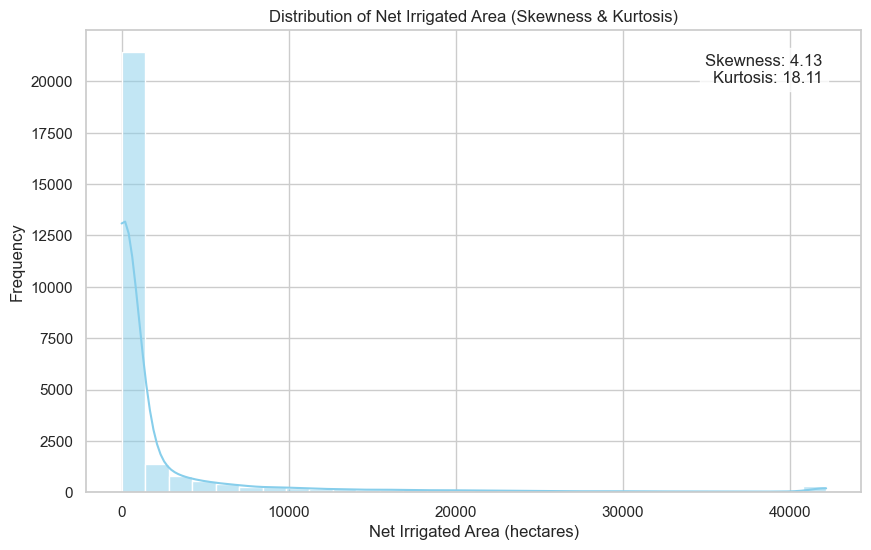

C:\Users\CC\AppData\Local\Temp\ipykernel_9684\3895913944.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Social group type', y='Net irrigated area of holdings receiving irrigation',


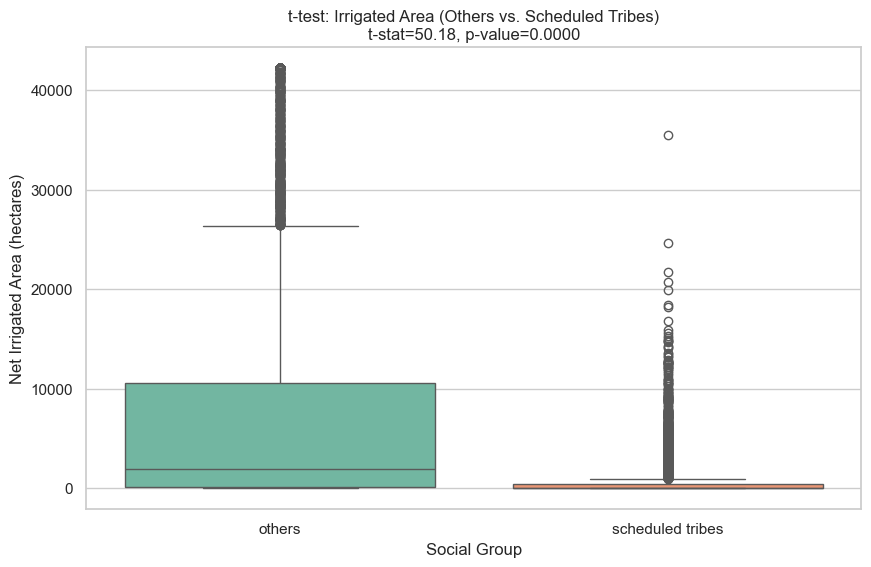

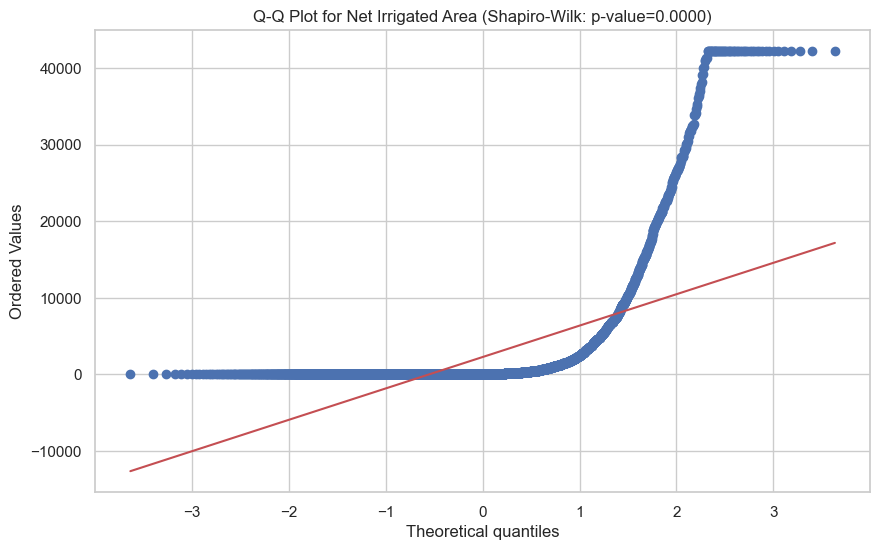

C:\Users\CC\AppData\Local\Temp\ipykernel_9684\3895913944.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='Feature', data=vif_data.sort_values('VIF', ascending=False), palette='viridis')


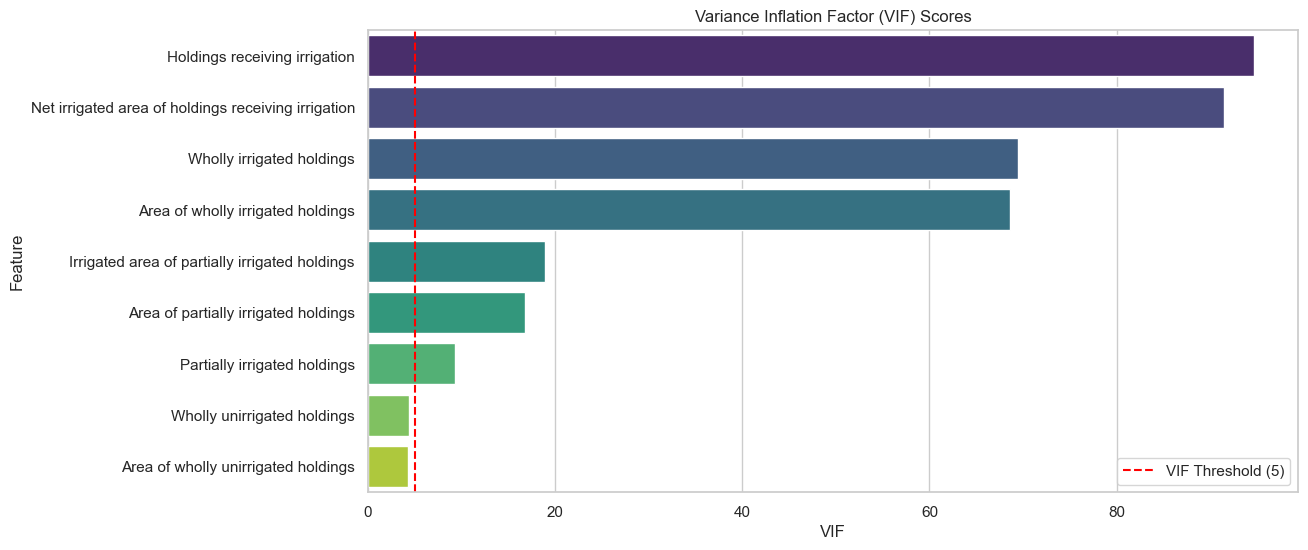

<Figure size 1200x600 with 0 Axes>

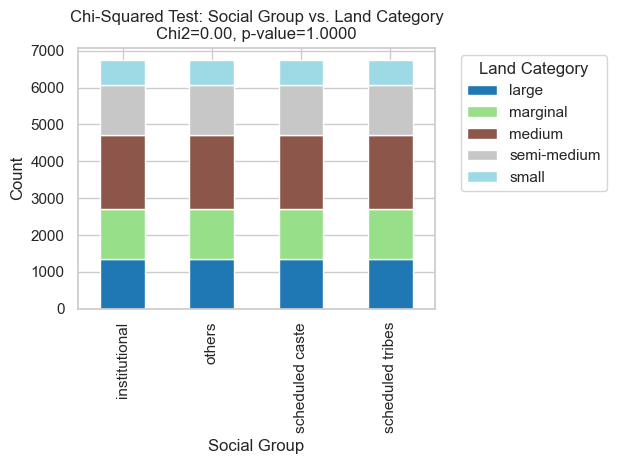

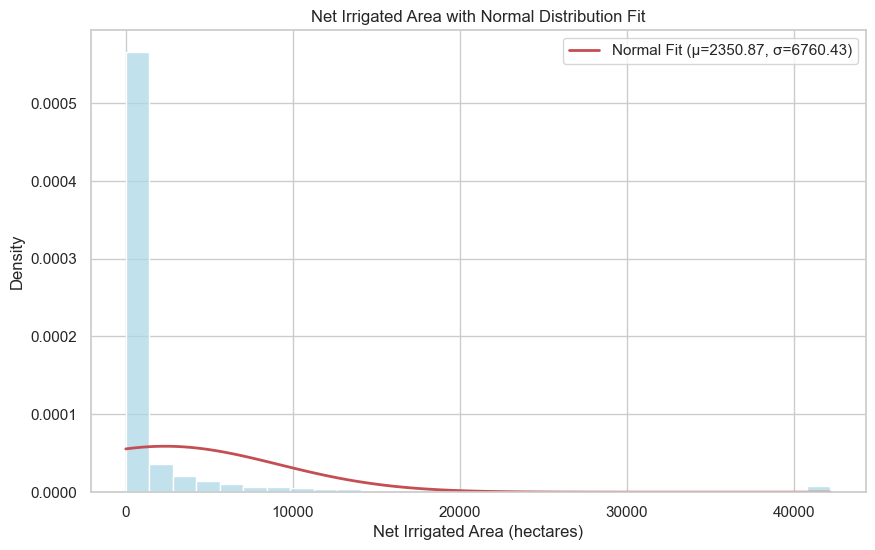

C:\Users\CC\AppData\Local\Temp\ipykernel_9684\3895913944.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Irrigation_type', y='Holdings receiving irrigation', data=df, palette='Set3')


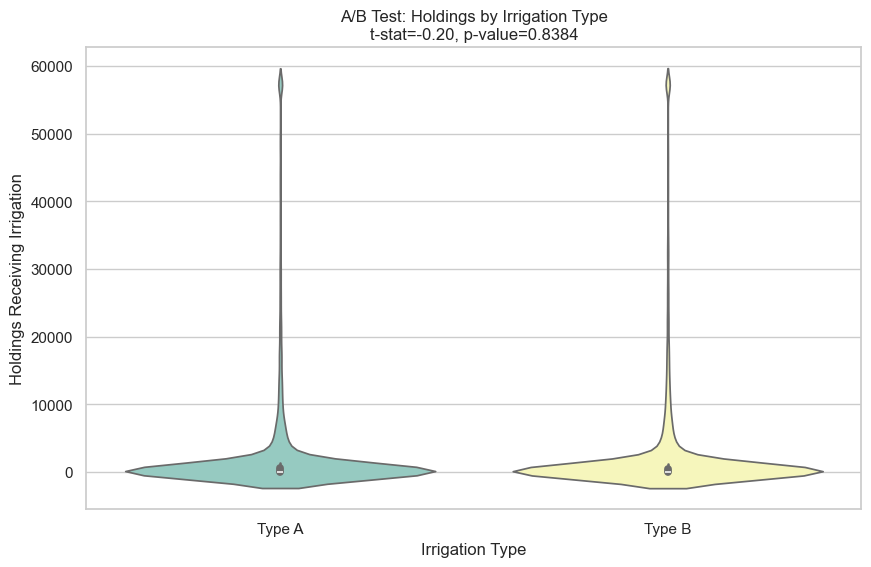

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load cleaned dataset
df = pd.read_csv('cleaned_agriculture_data.csv')

# Set Seaborn style
sns.set(style='whitegrid')

# 1. Descriptive Statistics (Skewness and Kurtosis)
# Graph: Histogram with KDE to show distribution shape
plt.figure(figsize=(10, 6))
sns.histplot(df['Net irrigated area of holdings receiving irrigation'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Net Irrigated Area (Skewness & Kurtosis)')
plt.xlabel('Net Irrigated Area (hectares)')
plt.ylabel('Frequency')
skewness = df['Net irrigated area of holdings receiving irrigation'].skew()
kurtosis = df['Net irrigated area of holdings receiving irrigation'].kurtosis()
plt.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# 2. t-test (Others vs. Scheduled Tribes)
# Graph: Boxplot to compare distributions
others = df[df['Social group type'] == 'others']['Net irrigated area of holdings receiving irrigation']
st = df[df['Social group type'] == 'scheduled tribes']['Net irrigated area of holdings receiving irrigation']
t_stat, p_value = stats.ttest_ind(others, st, equal_var=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Social group type', y='Net irrigated area of holdings receiving irrigation', 
            data=df[df['Social group type'].isin(['others', 'scheduled tribes'])], palette='Set2')
plt.title(f't-test: Irrigated Area (Others vs. Scheduled Tribes)\nt-stat={t_stat:.2f}, p-value={p_value:.4f}')
plt.xlabel('Social Group')
plt.ylabel('Net Irrigated Area (hectares)')
plt.show()

# 3. Shapiro-Wilk Test (Normality)
# Graph: Q-Q Plot to assess normality
shapiro_stat, shapiro_p = stats.shapiro(df['Net irrigated area of holdings receiving irrigation'].sample(5000, random_state=42))

plt.figure(figsize=(10, 6))
stats.probplot(df['Net irrigated area of holdings receiving irrigation'].sample(5000, random_state=42), dist="norm", plot=plt)
plt.title(f'Q-Q Plot for Net Irrigated Area (Shapiro-Wilk: p-value={shapiro_p:.4f})')
plt.show()

# 4. Variance Inflation Factor (VIF)
# Graph: Bar plot of VIF scores
numerical_cols = [
    'Wholly irrigated holdings', 'Area of wholly irrigated holdings',
    'Wholly unirrigated holdings', 'Area of wholly unirrigated holdings',
    'Partially irrigated holdings', 'Irrigated area of partially irrigated holdings',
    'Area of partially irrigated holdings', 'Holdings receiving irrigation',
    'Net irrigated area of holdings receiving irrigation'
]
X = df[numerical_cols].dropna()
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

plt.figure(figsize=(12, 6))
sns.barplot(x='VIF', y='Feature', data=vif_data.sort_values('VIF', ascending=False), palette='viridis')
plt.title('Variance Inflation Factor (VIF) Scores')
plt.xlabel('VIF')
plt.ylabel('Feature')
plt.axvline(x=5, color='red', linestyle='--', label='VIF Threshold (5)')
plt.legend()
plt.show()

# 5. Chi-Squared Test (Social Group vs. Land Category)
# Graph: Stacked bar plot of contingency table
contingency_table = pd.crosstab(df['Social group type'], df['Category of holdings'])
chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)

plt.figure(figsize=(12, 6))
contingency_table.plot(kind='bar', stacked=True, colormap='tab20')
plt.title(f'Chi-Squared Test: Social Group vs. Land Category\nChi2={chi2_stat:.2f}, p-value={chi2_p:.4f}')
plt.xlabel('Social Group')
plt.ylabel('Count')
plt.legend(title='Land Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Probability Distribution Fitting (Normal Distribution)
# Graph: Histogram with fitted normal distribution
mu, sigma = stats.norm.fit(df['Net irrigated area of holdings receiving irrigation'])
x = np.linspace(df['Net irrigated area of holdings receiving irrigation'].min(), 
                df['Net irrigated area of holdings receiving irrigation'].max(), 100)
normal_pdf = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 6))
sns.histplot(df['Net irrigated area of holdings receiving irrigation'], bins=30, stat='density', color='lightblue')
plt.plot(x, normal_pdf, 'r-', lw=2, label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')
plt.title('Net Irrigated Area with Normal Distribution Fit')
plt.xlabel('Net Irrigated Area (hectares)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 7. A/B Testing (Type A vs. Type B Irrigation)
# Graph: Violin plot to compare distributions
np.random.seed(42)
df['Irrigation_type'] = np.random.choice(['Type A', 'Type B'], size=len(df))
type_a = df[df['Irrigation_type'] == 'Type A']['Holdings receiving irrigation']
type_b = df[df['Irrigation_type'] == 'Type B']['Holdings receiving irrigation']
t_stat_ab, p_value_ab = stats.ttest_ind(type_a, type_b, equal_var=False)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Irrigation_type', y='Holdings receiving irrigation', data=df, palette='Set3')
plt.title(f'A/B Test: Holdings by Irrigation Type\nt-stat={t_stat_ab:.2f}, p-value={p_value_ab:.4f}')
plt.xlabel('Irrigation Type')
plt.ylabel('Holdings Receiving Irrigation')
plt.show()